# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

In [334]:
from collections.abc import Sequence
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [335]:
## One hot for numpy
def np_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

## **Sampling Behaviour of `tfp.Distributions`**

In [336]:
## tfd.Categorical sampling behaviour:
probs = tf.constant([[0., 0., 1.], 
                     [1., 0., 0.]])
print(probs.shape)
tfd.Categorical(probs=probs).sample(4).numpy()

(2, 3)


array([[2, 0],
       [2, 0],
       [2, 0],
       [2, 0]])

In [337]:
## tfd.Dirichlet sampling behavious:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
tfd.Dirichlet(conc).sample().numpy()

array([[0.02140409, 0.01427036, 0.9643255 ],
       [0.38862276, 0.16176145, 0.44961584]], dtype=float32)

$\rightarrow$ Samples come in by row. For Categorical the sample size is flexible. For Dirichlet the sample cise is bounded to the concentrations.

## **Setting up Topics and Data**

1. Specify global parameters

In [338]:
## Constructing iterator for single documents N's
class sliceConverter(Sequence):
    def __init__(self, N_D: tf.Tensor):
        assert N_D.ndim == 1
        N_idx = tf.cumsum(N_D)
        N_idx = tf.repeat(N_idx, 2)
        self.N_idx = tf.concat([[0], N_idx], axis=0).numpy()
        self.single_lengths = N_D

    def __len__(self):
        return int((self.N_idx.shape[0] - 1) / 2)

    def __getitem__(self, k):
        # if type(k) == int:
        #     if k >= 0:
        #         return tf.range(self.N_idx[2*k], self.N_idx[2*k + 1])
        #     if k < 0:
        #         i = len(self) + k
        #         return tf.range(self.N_idx[2*i], self.N_idx[2*i + 1])
        # elif type(k) == slice:
        #     start, stop, step = k.indices(len(self))
        #     return [self[i] for i in range(start, stop, step)]
        if type(k) == int:
            if k >= 0:
                return slice(self.N_idx[2*k], self.N_idx[2*k + 1], 1)
            if k < 0:
                i = len(self) + k
                return slice(self.N_idx[2*i], self.N_idx[2*i + 1], 1)
        elif type(k) == slice:
            start, stop, step = k.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        else:
            raise TypeError("Index must be integer or slice.")

    def __iter__(self):
        self.idx = 0
        self.maxiter = len(self)
        return self

    def __next__(self):
        if self.idx < self.maxiter:
            ret = self.__getitem__(self.idx)
            self.idx += 1
            return ret
        else:
            raise StopIteration

In [339]:
## Number of Topics
K = 10

## Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
sqrtV = 5

## Number of documents
D = 1000

## Number of words per document
N_D_dist = tfd.Poisson(rate=100)
N_D     = tf.cast(N_D_dist.sample(D), dtype=tf.int32)
N_total = tf.reduce_sum(N_D)
N_max   = tf.reduce_max(N_D)
N_idx = sliceConverter(N_D)

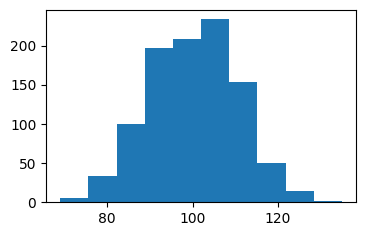

In [340]:
plt.figure(figsize=(4, 2.5))
plt.hist(N_D)
plt.show()

2. Generating Data

In [341]:
## Word grid
V = int(sqrtV**2)
V_grid = np.reshape(np.arange(0, V), newshape=(sqrtV, sqrtV))

## Topic-Word Distribution
#  Words belonging to a topic are rows and columns
Theta_idx = [row for row in V_grid] + [col for col in V_grid.T]
Theta = np.zeros((K, V))
for k, idx in enumerate(Theta_idx):
    Theta[k, idx] = 1. / sqrtV
Theta = tf.constant(Theta, dtype=tf.float32)

In [342]:
## Document-Topic Distribution
Alpha = 1
dist_Pi = tfd.Dirichlet(K*[Alpha])
Pi      = dist_Pi.sample(D)

In [343]:
## Topic Assignments of word c_{dik} of word w_{di}
dist_C  = tfd.Categorical(probs=Pi)
C_NmaxD = dist_C.sample(N_max)

C = []
for d in range(D):
    C_col = C_NmaxD[:N_D[d], d]
    C.append(C_col)

C = tf.concat(C, axis=0)
assert C.ndim == 1 and C.shape[0] == N_total

C_one_hot = tf.one_hot(C, depth=K, axis=-1)
assert tf.reduce_all(tf.reduce_sum(C_one_hot, axis=-1) == 1)

In [344]:
## Draw words w_{di}
dist_W = tfd.Categorical(tf.gather(Theta, C))
W = dist_W.sample()

In [345]:
## To extract topic-word assignments and document-words for a 
#  specific document, use the slice converter:
doc_slice = N_idx[11]

print("Topics for the Words in Document d=11:")
print(C[doc_slice])
print("\nWords in Document d=11:")
print(W[doc_slice])

Topics for the Words in Document d=11:
tf.Tensor(
[8 8 1 8 8 8 3 8 1 1 8 4 0 6 3 1 9 8 8 4 8 1 9 1 7 3 0 3 8 8 4 3 8 9 3 9 6
 1 3 8 9 2 3 8 3 8 8 5 9 6 3 1 5 0 0 9 3 1 1 4 3 8 0 9 5 8 1 0 9 0 1 1 3 8
 3 3 8 3 0 3 0 7 3 3 0 8 9 8 0 5 9 3 3 7 5 2 0 8 5 0 1 3 5 1 5 0 5 8 5 8 3
 9 8 3 8 8 8 3 0 6 3], shape=(121,), dtype=int32)

Words in Document d=11:
tf.Tensor(
[ 1  7  8 12  6  6 23 23 10  1 16 21 18 14 21 10  7  3 15 15  8 22 22 12
 24 18 13  8 13 20  9 18 15 22  0 21  0 10 22 15 10 12  0  2 16  2 23 10
  5 21 21 16  8 16  6 21  6 14  1 18  3 22 17 19  0  1  6  3 16 15 10 16
 21 19  5 20 24 17 11 13 21  8 18 13 15 11  4 14 19 15 21 10 23 24  8 22
 17  2  0 19  5  6  7 23  2  0 20  9 16 14  5 11  4 11  5  3  0 14  4 19
 16], shape=(121,), dtype=int32)


In [346]:
## For development purposes:
def print_all_shapes():
    print("Π-Shape")
    print(Pi.shape)
    print("\nΘ-Shape")
    print(Theta.shape)
    print("\nC-Shape")
    print(C.shape)
    print("\nC_one_hot-Shape")
    print(C_one_hot.shape)
    print("\nW-Shape")
    print(W.shape)

## Visualization

In [347]:
def format_to_img(arr, sqrtV=5):
    vals = dict(zip(*np.unique(arr, return_counts=True)))
    img = []

    for i in range(V):
        if i in vals:
            img.append(vals[i])
        else:
            img.append(0)

    img = np.array(img).reshape(sqrtV, sqrtV)

    return img

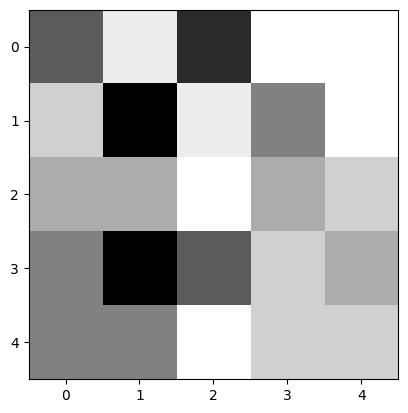

In [348]:
plt.imshow(format_to_img(W[N_idx[10]]), cmap="Greys")

## Gibbs Sampler

#### N-Tensor
One efficiency crtitical step is to vectorize 
$$
    n_{dkv} =  \{i \, \vert \, w_{di} == v \ \& \ c_{idk} ==1\}
$$
as much as possible. Due to the fact, that the document lengths are variable there is the choice between looping over the number of documents or padding the documents to a unique length. The padding does not need a word-token, it can be done by padding the $C$ matrix with $0$, therefore it will not affect $N$. Then the counting can be realized by stacking $W$ $K$ times along the last axis to match the shape of $C$.

In [349]:
def multiloop_N_tensor(W, C_one_hot, N_idx, D=1000, V=25):
    K = C_one_hot.shape[1]
    W         = W.numpy()
    C_one_hot = C_one_hot.numpy()
    N_DKV = np.zeros(shape=(D, K, V))
    
    for d in tqdm(range(D)):
        di = N_idx[d]
        for k in range(K):
            for v in range(V):
                for w_di, c_dik in zip(W[di], C_one_hot[di, k]):
                    if w_di == v and c_dik == 1:
                        N_DKV[d, k, v] += 1

    return N_DKV

In [350]:
# N_test1 = multiloop_N_tensor(W, C_one_hot, N_idx)

In [351]:
# %timeit multiloop_N_tensor(W, C_one_hot, N_idx)

In [352]:
def singleloop_N_tensor(W, C_one_hot, N_idx, D=1000, V=25, verbose=False):
    K = C_one_hot.shape[1]
    W         = W.numpy()
    C_one_hot = C_one_hot.numpy()
    N_DKV = np.zeros(shape=(D, K, V))

    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to 25 instead from 0 to 24. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W + 1
    
    if verbose:
        iter = tqdm(range(D))  
    if not verbose:
        iter = range(D)

    for d in iter:
        di = N_idx[d]
        W_ = Wp1[di]
        C_one_hot_ = C_one_hot[di]

        Nd = len(W_)

        ## Stacking W
        W_stacked = np.stack(K*[W_], axis=-1)

        ## Elementwise product combines logical & in conditio
        #  Choosing int32 as product dtype for efficiency.
        C_Dot_W = np.multiply(W_stacked, C_one_hot_)

        ## The v-dimension of N is a one-hot encoding for the vocabulary:
        N_dNdKVp1 = np_one_hot(C_Dot_W.astype(np.int32), V+1)

        ## Reverting the v-shift by dropping the 0 one-hot dimension
        N_dNdKV = N_dNdKVp1[:, :, 1:]

        ## Summing along v-dimension
        assert N_dNdKV.shape[0] == Nd
        N_dKV = np.sum(N_dNdKV, axis=0)

        ## Append to full tensor
        N_DKV[d, :, :] = N_dKV

    return N_DKV

In [353]:
N_test2 = singleloop_N_tensor(W, C_one_hot, N_idx)

In [354]:
# %timeit singleloop_N_tensor(W, C_one_hot, N_idx)

In [355]:
print(f"Numpy implementation which avoides all loops but the loop over documents is about a factor {round(8150./129., 1)} more efficient as multiloop version.")

Numpy implementation which avoides all loops but the loop over documents is about a factor 63.2 more efficient as multiloop version.


In [356]:
def fungen_pad_CW(N_idx):
    
    @tf.function
    def padd_CW(W, C_one_hot):
        K = C_one_hot.shape[1]

        ## Reshaping C to C_DNmaxK and
        #            W to W_DNmax
        C_DNmaxK_list = []
        W_DNmax_list  = []
        N_max = tf.reduce_max(N_idx.single_lengths)

        for di in N_idx:
            CdiK = C_one_hot[di, :]
            Wdi  = W[di]
            Nd   = CdiK.shape[0]

            N_pad = N_max - Nd

            ## C
            pad = tf.zeros(shape=(N_pad, K), dtype=CdiK.dtype)
            CdiK_pad = tf.concat([CdiK, pad], axis=0)
            C_DNmaxK_list.append(CdiK_pad)

            ## W
            pad = tf.zeros(shape=(N_pad), dtype=Wdi.dtype)
            Wdi_pad = tf.concat([Wdi, pad], axis=0)
            W_DNmax_list.append(Wdi_pad)

        C_DNmaxK = tf.stack(C_DNmaxK_list, axis=0)
        W_DNmax  = tf.stack(W_DNmax_list, axis=0)

        return W_DNmax, C_DNmaxK

    return padd_CW

## Using a tf.function decorator causes the creation to take pretty long because a graph
#  is built which has to take the document lengths into account. This might be only 
#  useful if the function itself takes long to run without a tf.function... Maybe
#  Better use just the plain-non tf.function-converted:

def padd_CW(W, C_one_hot, N_idx):
    K = C_one_hot.shape[1]

    ## Reshaping C to C_DNmaxK and
    #            W to W_DNmax
    C_DNmaxK_list = []
    W_DNmax_list  = []
    N_max = tf.reduce_max(N_idx.single_lengths)

    for di in N_idx:
        CdiK = C_one_hot[di, :]
        Wdi  = W[di]
        Nd   = CdiK.shape[0]

        N_pad = N_max - Nd

        ## C
        pad = tf.zeros(shape=(N_pad, K), dtype=CdiK.dtype)
        CdiK_pad = tf.concat([CdiK, pad], axis=0)
        C_DNmaxK_list.append(CdiK_pad)

        ## W
        pad = tf.zeros(shape=(N_pad), dtype=Wdi.dtype)
        Wdi_pad = tf.concat([Wdi, pad], axis=0)
        W_DNmax_list.append(Wdi_pad)

    C_DNmaxK = tf.stack(C_DNmaxK_list, axis=0)
    W_DNmax  = tf.stack(W_DNmax_list, axis=0)

    return W_DNmax, C_DNmaxK



In [357]:
# %timeit tf_padd_CW(W, C_one_hot)

In [358]:
# %timeit padd_CW(W, C_one_hot, N_idx)

In [359]:
print(f"With a tf.function the padding is about a factor {round(970./63., 1)} more efficient, when the graph is already constructed. Yet constructing the graph takes a while.")

With a tf.function the padding is about a factor 15.4 more efficient, when the graph is already constructed. Yet constructing the graph takes a while.


In [360]:
W_DNmax, C_DNmaxK = padd_CW(W, C_one_hot, N_idx)
# tf_padd_CW = fungen_pad_CW(N_idx)
# W_DNmax, C_DNmaxK = tf_padd_CW(W, C_one_hot)

In [361]:
@tf.function
def tf_N_tensor(W_DNmax, C_DNmaxK, V=25):

    ## Extracting shapes
    D = C_DNmaxK.shape[0]
    N = C_DNmaxK.shape[1]
    K = C_DNmaxK.shape[2]
    
    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to 25 instead from 0 to 24. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W_DNmax + 1
    W_stacked = tf.stack(K*[Wp1], axis=-1)    

    ## Elementwise product combines logical & in condition.
    #  Choosing int32 as product dtype for efficiency.
    C_DNmaxK_int = tf.cast(C_DNmaxK, dtype=tf.int32)
    C_Dot_W = tf.math.multiply(W_stacked, C_DNmaxK_int)

    ## The v-dimension of N is a one-hot encoding for the vocabulary:
    N_DNKVp1 = tf.one_hot(C_Dot_W, V+1, dtype=tf.int32)

    ## Reverting the v-shift by dropping the 0 one-hot dimension
    N_DNKV = N_DNKVp1[:, :, :, 1:]

    ## Summing along v-dimension
    assert N_DNKV.shape[1] == N
    N_DKV = tf.reduce_sum(N_DNKV, axis=1)

    ## Turn to float for gibbs sampler
    N_DKV = tf.cast(N_DKV, dtype=tf.float32)

    return N_DKV

In [362]:
# %timeit tf_N_tensor(W_DNmax, C_DNmaxK)

In [363]:
print(f"The padded tf Version is about a factor {round(129./37, 1)} more efficient than the numpy-vectorized version.")

The padded tf Version is about a factor 3.5 more efficient than the numpy-vectorized version.


In [364]:
N_test3 = tf_N_tensor(W_DNmax, C_DNmaxK)
tf.reduce_all(N_test3 == N_test2)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### **Sampling $C$**

Sampling $\Theta$ and $\Pi$ is not very problematic because they are just dirichlet distributed (below). Sampling $C$ is sampling from 
$$
    p(C\vert \Theta, \Pi, W)=\prod_{d=1}^D \prod_{i=1}^{I_d} \frac{\prod_{k=1}^K \left(\pi_{dk}\theta_{kw_{di}}\right)^{c_{dik}}}{\sum_{k'=1}^K\left(\pi_{dk'}\theta_{k'w_{di}}\right)}
$$ 
which is a categorical distribution. The dependence of $I_d$ is somewhat entangled in the $w_{di}$ index of $\Theta_{kw_{di}}$. A fully vectorized solution without loop over $D$ therefore again needs padding.

https://youtu.be/z2q7LhsnWNg?t=3878

In [365]:
W_DNmax, C_DNmaxK = padd_CW(W, C_one_hot, N_idx)
print_all_shapes()
print("\nC_one_hot_padded-Shape")
print(C_DNmaxK.shape)
print("\nW_padded-Shape")
print(W_DNmax.shape)

Π-Shape
(1000, 10)

Θ-Shape
(10, 25)

C-Shape
(100174,)

C_one_hot-Shape
(100174, 10)

W-Shape
(100174,)

C_one_hot_padded-Shape
(1000, 135, 10)

W_padded-Shape
(1000, 135)


In [366]:
def singleloop_sample_C(Theta, Pi, W):
    for d in range(D):
        pass

In [367]:
def sample_C(Theta, Pi, W_DNmax):

    ## Numerator
    # Theta_block = tf.cast(tf.stack(D*[Theta]), dtype=tf.float32)
    # Pi_block = tf.cast(tf.stack(V*[Pi], axis=-1), dtype=tf.float32)
    # numerator = tf.math.multiply(Pi_block, Theta_block)
    Theta_KDNmax = tf.gather(Theta, W_DNmax, axis=-1) 
    Pi_block = tf.stack(Theta_KDNmax.shape[2]*[tf.transpose(Pi)], axis=-1)
    numerator = tf.math.multiply(Pi_block, Theta_KDNmax)

    ## Denominator
    # denominator = tf.reduce_sum(numerator, axis=1)

    ## Sampling
    C_dist = tfd.Categorical(numerator)
    C = C_dist.sample()

    return C

In [368]:
## For Tets purposes: Calculate Theta_KW in loop once.
# Theta_KW_1 = np.zeros(shape=(K, len(W)))

# Theta_temp = Theta.numpy()
# W_temp = W.numpy()
# for k in tqdm(range(K)):
#     for i, w in enumerate(W_temp):
#         Theta_KW_1[k, i] = Theta[k, w]

In [371]:
# TODO:
test = sample_C(Theta, Pi, W_DNmax)
test.shape

TensorShape([10, 1000])

In [323]:
Theta_KDNmax = tf.gather(Theta, W_DNmax, axis=-1) 
Theta_KDNmax.shape

TensorShape([10, 1000, 135])

In [328]:
Pi_block = tf.stack(Theta_KDNmax.shape[2]*[tf.transpose(Pi)], axis=-1)

In [330]:
numerator = tf.math.multiply(Pi_block, Theta_KDNmax)
numerator.shape

TensorShape([10, 1000, 135])

In [331]:
denominator = tf.reduce_sum(numerator, axis=0)

In [246]:
Theta_block = tf.cast(tf.stack(D*[Theta]), dtype=tf.float32)
Pi_block = tf.cast(tf.stack(V*[Pi], axis=-1), dtype=tf.float32)
numerator = tf.math.multiply(Pi_block, Theta_block)
numerator.shape

TensorShape([1000, 10, 25])

In [197]:
# test_tensor = tf.cast(Theta[:, W], dtype=tf.float32)
# Theta = tf.cast(Theta, dtype=tf.float32)

# d = np.random.randint(0, 1000, 1000)
# k = np.random.randint(0, 10,   1000)
# v = np.random.randint(0, 25,   1000)

# for i, j, l in zip(d, k, v):
#     test_element = Theta[: W[d, i]]

### **Sampling $\Theta$ and $\Pi$**

Sampling $\Theta$ and $\Pi$:
$$
    \begin{align*}
        p(\Theta\vert C, W) &= \prod_{k=1}^K \mathcal D(\theta_k; \ \beta_{k:} + n_{\cdot k:}) \\
        p(\Pi\vert C, W)    &= \prod_{d=1}^D \mathcal D(\pi_d; \ \alpha_{d:} + n_{d:\cdot}) \, .
    \end{align*}
$$
$\Theta$ and $\Pi$ are neither dependent on the number of words per document nor do they have an $I_d$ dimension. Therefore it is much easier to sample them:

In [204]:
@tf.function
def sample_Theta(N_DKV, beta):
    dist_Theta = tfd.Dirichlet(beta + tf.reduce_sum(N_DKV, axis=0))
    Theta      = dist_Theta.sample()
    return Theta

@tf.function
def sample_Pi(N_DKV, alpha):
    dist_Pi = tfd.Dirichlet(alpha + tf.reduce_sum(N_DKV, axis=-1))
    Pi      = dist_Pi.sample()
    return Pi

In [205]:
## Random Initialization of Prior Alpha and Beta.
#  They do not acutally matter much but could be optimized by Type II MAP or MLE.
beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)

## Calculate one N_DKV for test purposes
W_DNmax, C_DNmaxK = padd_CW(W, C_one_hot, N_idx)
N_test = tf_N_tensor(W_DNmax, C_DNmaxK)

In [206]:
test_Theta = sample_Theta(N_test, beta)
test_Pi    = sample_Pi(N_test, alpha)

assert test_Theta.shape == Theta.shape
assert test_Pi.shape == Pi.shape

#### Main Loop

In [439]:
N_iter = 200
Theta_store = []
W_ = W

C0         = np.random.randint(0, 10,  size=(D, N))
C0_one_hot = tf.one_hot(C0, depth=K, axis=-1)

alpha0 = np.random.randint(0, 10,  size=(D, N))
beta0  = np.random.normal(size=(D, K))

In [ ]:
# for iter in  tqdm(range(N_iter)):
#     Ndkv = 
#     Theta_it = tfd.Dirichlet()